In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.layers import AveragePooling1D, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dense, LSTM, Input, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import Adamax, Adadelta, Adagrad, Ftrl, Nadam, RMSprop, SGD
from keras.models import load_model
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/weather_2017+2018_hourly.csv")
data_as_np = dataset.GHI.values

In [ ]:
def series_to_supervised(data_np,n_lags,n_outs):
    samples = len(data_np)-(n_lags+n_outs-1)
    Inputs = []
    Targets = np.empty((samples,n_outs))
    for i in range(samples):
        step = i+n_lags
        sample = data_np[i:step]
        Inputs.append(sample)
        label = data_np[step:(step+n_outs)]
        j = 0
        for a in label:
            Targets[i,j] = a
            j = j+1
    return np.array(Inputs),Targets

In [ ]:
def plot_model_history(model_summary):
    plt.plot(model_summary.history['loss'])
    plt.plot(model_summary.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='upper right')
    plt.show()

In [ ]:
def rmse_error(pred,y):
    return np.sqrt(mean_squared_error(pred,y))

In [ ]:
def create_model_fnAPI(input_shape,n_out,train_x,train_y,test_x,test_y):
  inputs = Input(shape = input_shape)
  lyr1 = TimeDistributed(Conv1D(filters = 64, kernel_size = 3, activation='leaky_relu'))(inputs)
  lyr2 = TimeDistributed(AveragePooling1D(pool_size = 4))(lyr1)

  #lyr4 = TimeDistributed(Conv1D(filters = 64, kernel_size = 3, activation='leaky_relu'))(lyr3)
  #lyr5 = TimeDistributed(AveragePooling1D(pool_size = 4))(lyr4)

  lyr7 = TimeDistributed(Flatten())(lyr2)
  lyr8 = LSTM(units = 64, activation='leaky_relu')(lyr7)
  lyr9 = Dropout(0.2)(lyr8)
  output = Dense(units = n_out, activation='leaky_relu')(lyr9)

  model = Model(inputs = inputs, outputs = output)

  #cp1 = ModelCheckpoint('CNNLSTM_final/', save_best_only = True)
  model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate = 0.00001), metrics=[RootMeanSquaredError()])
  model_summary = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 500, batch_size =  64)
  plot_model_history(model_summary)

  #model = load_model('CNNLSTM_final/')

  return model

In [ ]:
# Block for final output...............
data_np = data_as_np.reshape(-1,1)
n_steps = 120
n_seq = 2
n_out = 24
# Prepare data

test_rmse,test_mae,test_nmrse,test_r2score = 0,0,0,0
predictions = []
for _ in range(3):
  n_lags = n_steps * n_seq
  Inputs,Targets = series_to_supervised(data_np,n_lags,n_out)

  Inputs = Inputs.reshape((Inputs.shape[0],n_seq,n_steps,1))
  Inputs_model, Targets_model = Inputs[:-10], Targets[:-10]
  Inputs_plot, Targets_plot = Inputs[-10:], Targets[-10:]

  no_samples = Targets_model.shape[0]
  split = int(0.3 * no_samples)

  input_shape = (n_seq,n_steps,1)

  train_x,train_y = Inputs_model[:-split],Targets_model[:-split]
  test_x,test_y = Inputs_model[-split:],Targets_model[-split:]

  test_rmse,test_mae,test_nmrse,test_r2score = 0,0,0,0

  model = create_model_fnAPI(input_shape,n_out,train_x,train_y,test_x,test_y)

  train_pred,test_pred = model.predict(train_x), model.predict(test_x)
  predicted = model.predict(Inputs_plot)
  predictions.append(predicted)

  test_pred = test_pred.flatten()
  test_y = test_y.flatten()
  test_rmse = rmse_error(test_pred, test_y)
  test_mae = mean_absolute_error(test_pred, test_y)
  test_nmrse = test_rmse / test_y.mean()
  test_r2score = r2_score(test_pred, test_y)
  with open("/content/drive/MyDrive/CNNMLPerror.txt","a") as f:
        f.write(f"{test_rmse},{test_mae},{test_nmrse},{test_r2score} \n")

[Text(0.5, 0, 'Hours'), Text(0, 0.5, 'GHI')]

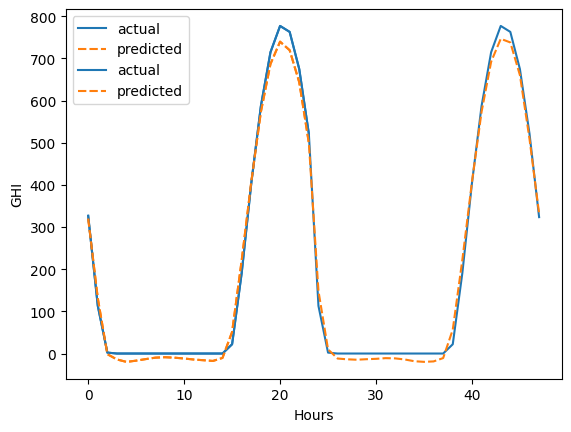

In [ ]:
# predicted values
predicted = np.array(predictions).mean(axis = 0)
actual = Targets_plot

# Next 1 day plotting
comp_df = pd.DataFrame({"actual":actual[0].flatten(),"predicted":predicted[0].flatten()})
ax = sns.lineplot(data = comp_df, legend="full")
ax.set(xlabel='Hours', ylabel='GHI')

# Next 2 day plotting
comp_df = pd.DataFrame({"actual":actual[0:2].flatten(),"predicted":predicted[0:2].flatten()})
ax = sns.lineplot(data = comp_df)
ax.set(xlabel='Hours', ylabel='GHI')

[Text(0.5, 0, 'Hours'), Text(0, 0.5, 'GHI')]

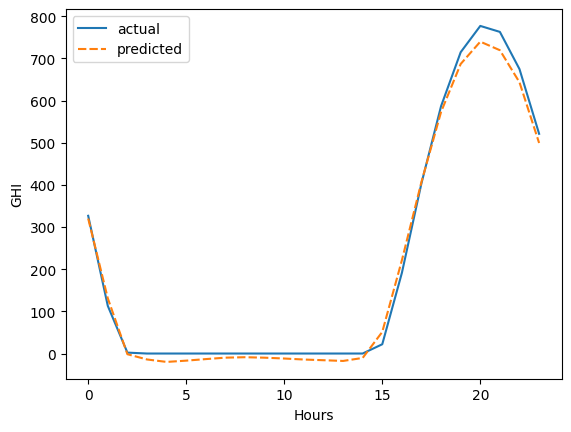

In [ ]:

# Next 1 day plotting
comp_df = pd.DataFrame({"actual":actual[0].flatten(),"predicted":predicted[0].flatten()})
ax = sns.lineplot(data = comp_df, legend="full")
ax.set(xlabel='Hours', ylabel='GHI')